In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import plotly.express as px


In [3]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

In [4]:
train_data['length'] = [len(x) for x in train_data['Comment']]

In [5]:
train_data

Comment  Emotion  length
0                                i didnt feel humiliated  sadness      23
1      i can go from feeling so hopeless to so damned...  sadness     108
2       im grabbing a minute to post i feel greedy wrong    anger      48
3      i am ever feeling nostalgic about the fireplac...     love      92
4                                   i am feeling grouchy    anger      20
...                                                  ...      ...     ...
15995  i just had a very brief time in the beanbag an...  sadness     101
15996  i am now turning and i feel pathetic that i am...  sadness     102
15997                     i feel strong and good overall      joy      30
15998  i feel like this was such a rude comment and i...    anger      59
15999  i know a lot but i feel so stupid because i ca...  sadness      62

[16000 rows x 3 columns]

In [6]:
train_data.shape


(16000, 3)

In [7]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [8]:
train_data.duplicated().sum()

1

In [9]:
fig = px.histogram(train_data, x="Emotion", title="Distribution of Emotions")
fig.show()

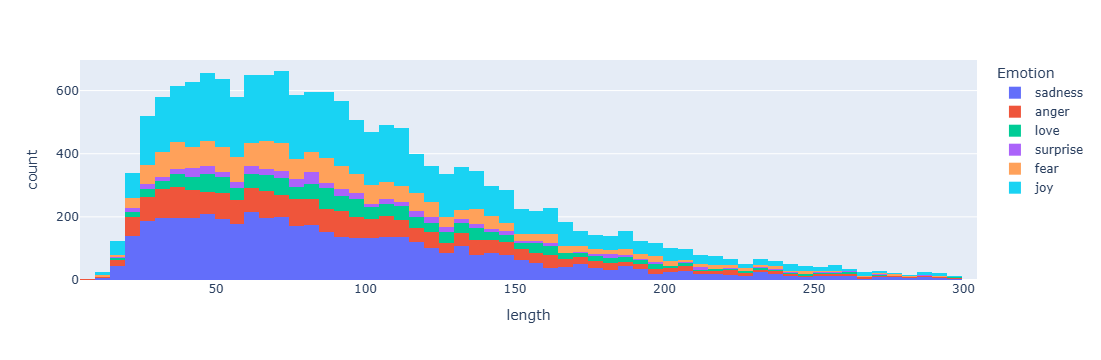

In [10]:
df1 = train_data.copy()
df1['length'] = [len(x) for x in train_data['Comment']]
lenght_value = df1['length'].values
fig = px.histogram(df1, x="length", color="Emotion", barmode="stack")
fig.show()

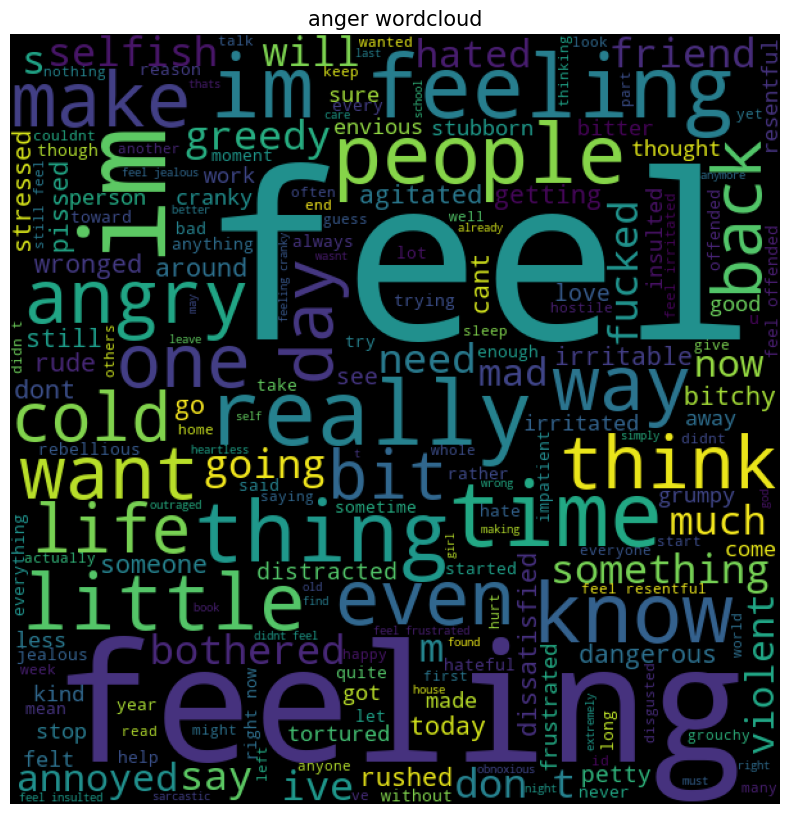

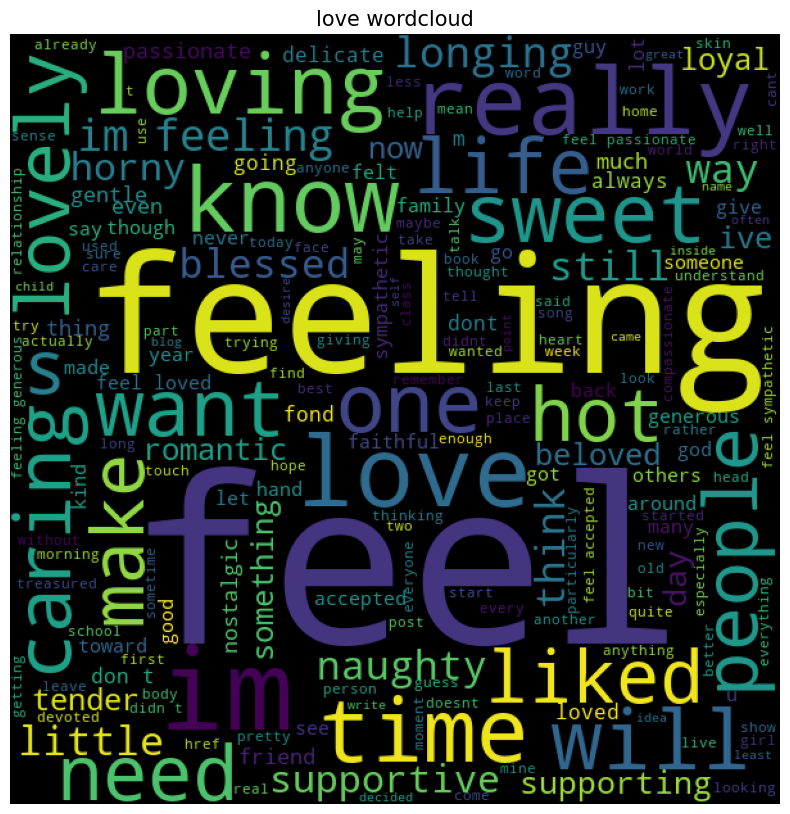

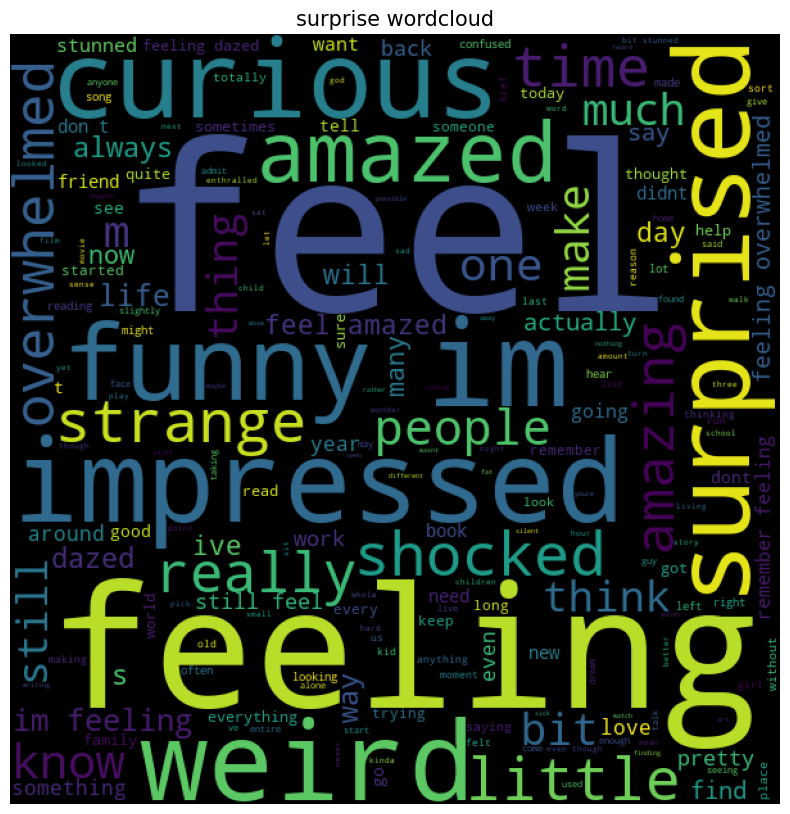

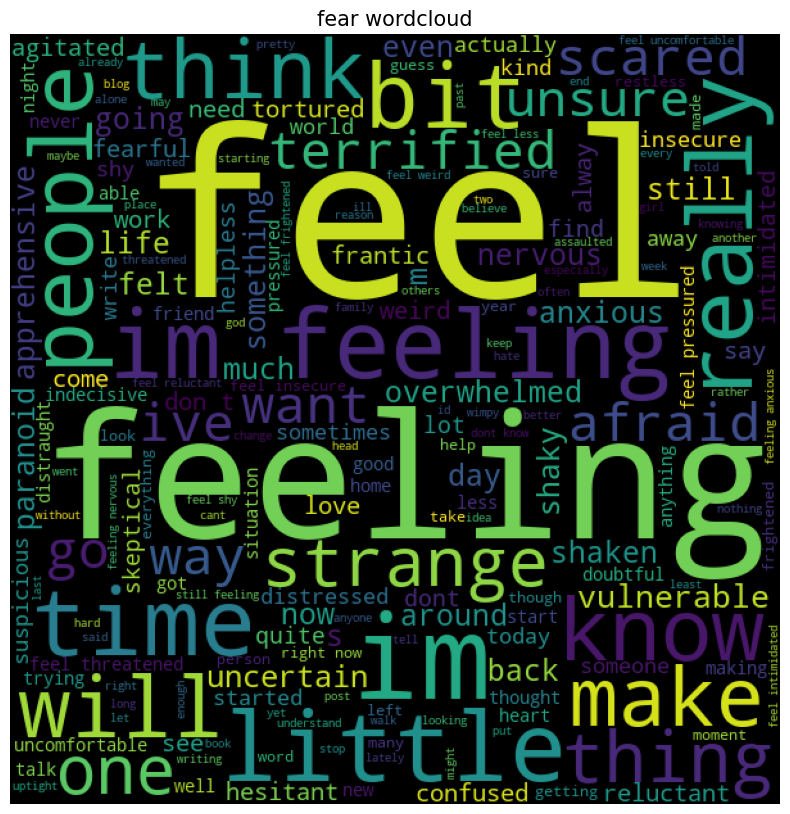

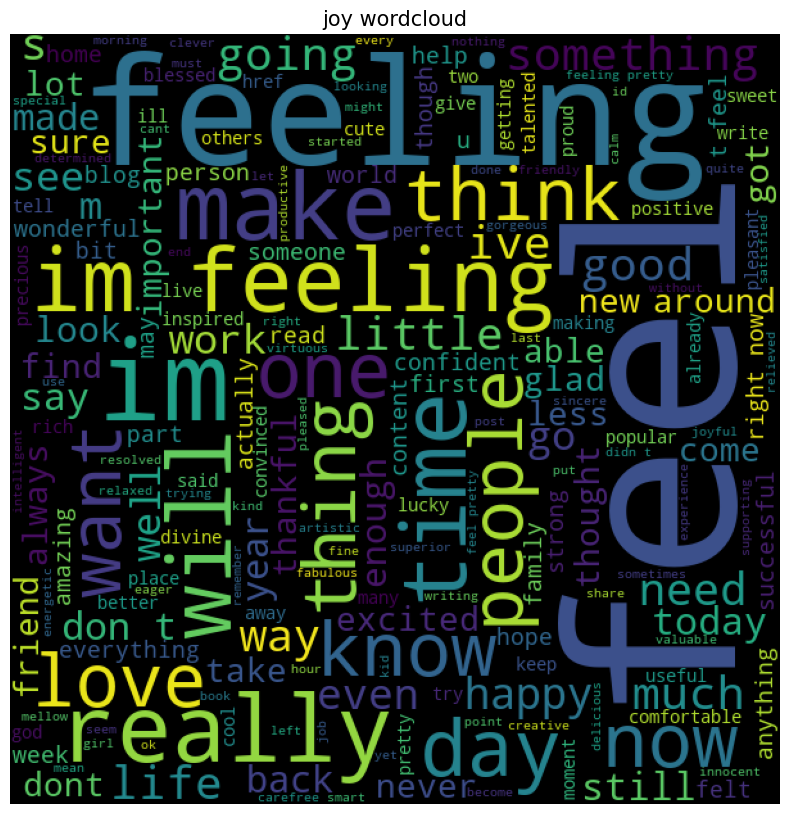

In [11]:
def cloud(wordcloud, df):
    plt.figure(figsize=(10,10))
    plt.title(df + ' wordcloud', size=15)
    plt.imshow(wordcloud)
    plt.axis('off')
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height=600).generate(text)
    cloud(wordcloud, emotion)

    

In [15]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [16]:
train_data.head()

Comment  Emotion  length
0                            i didnt feel humiliated        4      23
1  i can go from feeling so hopeless to so damned...        4     108
2   im grabbing a minute to post i feel greedy wrong        0      48
3  i am ever feeling nostalgic about the fireplac...        3      92
4                               i am feeling grouchy        0      20

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tqdm import tqdm
tqdm.pandas()

In [20]:
df = train_data.copy()

In [21]:
df.head()

Comment  Emotion  length
0                            i didnt feel humiliated        4      23
1  i can go from feeling so hopeless to so damned...        4     108
2   im grabbing a minute to post i feel greedy wrong        0      48
3  i am ever feeling nostalgic about the fireplac...        3      92
4                               i am feeling grouchy        0      20

In [25]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_data(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment']  = df['Comment'].progress_apply(clean_data)
# df['cleaned_comment']  = df['Comment'].apply(clean_data) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:08<00:00, 1948.70it/s]


In [26]:
df


Comment  Emotion  length  \
0                                i didnt feel humiliated        4      23   
1      i can go from feeling so hopeless to so damned...        4     108   
2       im grabbing a minute to post i feel greedy wrong        0      48   
3      i am ever feeling nostalgic about the fireplac...        3      92   
4                                   i am feeling grouchy        0      20   
...                                                  ...      ...     ...   
15995  i just had a very brief time in the beanbag an...        4     101   
15996  i am now turning and i feel pathetic that i am...        4     102   
15997                     i feel strong and good overall        2      30   
15998  i feel like this was such a rude comment and i...        0      59   
15999  i know a lot but i feel so stupid because i ca...        4      62   

                                         cleaned_comment  
0                                      didnt feel humili  
1      go feel hopeless damn hope around someon care ...  
2                   im grab minut post feel greedi wrong  
3         ever feel nostalg fireplac know still properti  
4                                           feel grouchi  
...                                                  ...  
15995      brief time beanbag said anna feel like beaten  
15996   turn feel pathet still wait tabl sub teach degre  
15997                            feel strong good overal  
15998                     feel like rude comment im glad  
15999                       know lot feel stupid portray  

[16000 rows x 4 columns]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size = 0.2, random_state=42)


In [30]:
tfidfvectorizer = TfidfVectorizer()
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)


In [34]:
X_train_tfidf.shape

(12800, 9257)

In [48]:

classifier={
    'MultinomialNB':MultinomialNB(),
    'LogisticRegression':LogisticRegression(),
    'Random Forest':RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

for name,clf in classifier.items():
    print(f"\n============{name}============")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"======={accuracy_tfidf}============")
    print("Classification Report")
    print(classification_report(y_test, y_pred_tfidf))
    


============MultinomialNB============
=======0.655============
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


============LogisticRegression============
=======0.829375============
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
      

In [50]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [54]:
def predict_emotion(input_text):
    cleaned_text = clean_data(input_text)
    input_vectorizer = tfidfvectorizer.transform([cleaned_text])
    
    predicted_label = lg.predict(input_vectorizer)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorizer))
    
    return predicted_emotion, label

In [58]:
predict_emotion("she is hurt")

('sadness', 4)

In [59]:
import pickle
pickle.dump(lg, open("Logistic_regression.pkl","wb"))
pickle.dump(lb, open("label_encoder.pkl","wb"))
pickle.dump(tfidfvectorizer, open("tfidfvectorizer.pkl","wb"))

In [63]:
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ",text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    return pad

In [64]:
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

In [65]:
model = Sequential()
model.add(Embedding(input_dim = 11000, output_dim = 150, input_length = 300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))
model.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs = 1, batch_size = 64, verbose = 1, callbacks=[callback])

C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 554ms/step - accuracy: 0.3111 - loss: 1.6476


C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss



In [67]:
model.save("model.h5")

In [71]:
from keras.models import load_model
model01 = load_model("model.h5")

In [68]:
def predictive_system_dl(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ",sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding="pre")
    return pad

In [79]:
sentence = predictive_system_dl("Im goging to kill you")
result = lb.inverse_transform(np.argmax(model.predict(sentence), axis = 1))[0]
prob = np.max(model.predict(sentence))
print(f"{result} with probability of {prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
anger with probability of 0.29018542170524597


In [80]:
with open("lb1.pkl","wb") as f:
    pickle.dump(lb,f)
vocab_info = {"vocab_size": 11000, "max_len":300}
with open("vocab_info.pkl","wb") as f:
    pickle.dump(vocab_info, f)